<a href="https://colab.research.google.com/github/annabellatian/mitFuturemakers/blob/main/detectingSarcasm/detectingSarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model
import matplotlib.pyplot as plt

In [17]:
# load the dataset
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Sarcasm_Headlines_Dataset.json', lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



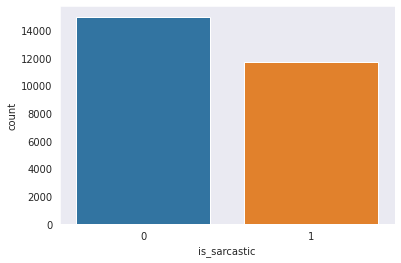

In [18]:
# plot class level distribution
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [19]:
df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [20]:
len(df.is_sarcastic)

26709

In [21]:
# define x and y
x = df.iloc[:, 1]
y = df.iloc[:, 2]
print(y)

0        0
1        0
2        1
3        1
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: is_sarcastic, Length: 26709, dtype: int64


In [23]:
# split dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
len(x_train)

21367

In [24]:
# data preprocessing
max_words = 1000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)
sequences_matrix.shape

(21367, 150)

In [25]:
sequences_matrix

array([[  0,   0,   0, ...,  12, 551, 495],
       [  0,   0,   0, ...,  59,  39,   2],
       [  0,   0,   0, ..., 777,  16,   1],
       ...,
       [  0,   0,   0, ...,   3,  55,   2],
       [  0,   0,   0, ...,   0, 125,  15],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [26]:
np.amax(sequences_matrix)

999

In [27]:
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [28]:
# compile the model
model = RNN()
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [31]:
# fit the model
history = model.fit(sequences_matrix, y_train, batch_size = 100, epochs = 5, validation_split = 0.1)


Epoch 1/5
193/193 [==============================] - 47s 145ms/step - loss: 0.5580 - accuracy: 0.6940 - val_loss: 0.4023 - val_accuracy: 0.8138
Epoch 2/5
193/193 [==============================] - 27s 141ms/step - loss: 0.3956 - accuracy: 0.8217 - val_loss: 0.3829 - val_accuracy: 0.8217
Epoch 3/5
193/193 [==============================] - 27s 142ms/step - loss: 0.3608 - accuracy: 0.8370 - val_loss: 0.3785 - val_accuracy: 0.8226
Epoch 4/5
193/193 [==============================] - 27s 142ms/step - loss: 0.3451 - accuracy: 0.8486 - val_loss: 0.3709 - val_accuracy: 0.8259
Epoch 5/5
193/193 [==============================] - 27s 141ms/step - loss: 0.6014 - accuracy: 0.8000 - val_loss: 0.3896 - val_accuracy: 0.8203


In [32]:
# evaluate on test set
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = max_len)
test_sequences_matrix.shape

(5342, 150)

In [33]:
accr = model.evaluate(test_sequences_matrix, y_test)
print('Test set\nLoss: {:0.3f}\nAccuracy: {:0.3f}'.format(accr[0], accr[1]))

167/167 [==============================] - 3s 20ms/step - loss: 0.3961 - accuracy: 0.8149
Test set
Loss: 0.396
Accuracy: 0.815


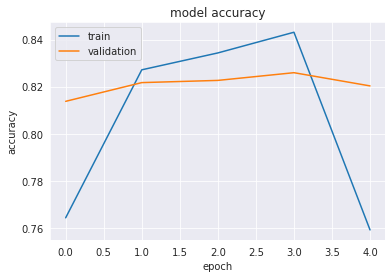

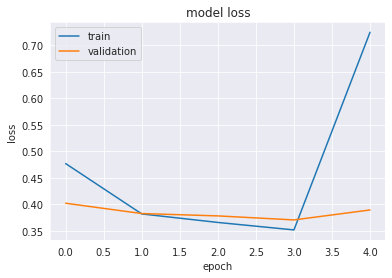

In [34]:
# plot the accuracy and loss curves
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()